In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv('/Users/Albert/Desktop/Thinkful_Drills/Data/Supervised Learning/NFL Play by Play 2009-2017.csv')
df.head()

/Users/Albert/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (25,51) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Date,GameID,Drive,qtr,down,time,TimeUnder,TimeSecs,PlayTimeDiff,SideofField,...,yacEPA,Home_WP_pre,Away_WP_pre,Home_WP_post,Away_WP_post,Win_Prob,WPA,airWPA,yacWPA,Season
0,2009-09-10,2009091000,1,1,NaN,15:00,15,3600.0,0.0,TEN,...,NaN,0.485675,0.514325,0.546433,0.453567,0.485675,0.060758,NaN,NaN,2009
1,2009-09-10,2009091000,1,1,1.0,14:53,15,3593.0,7.0,PIT,...,1.146076,0.546433,0.453567,0.551088,0.448912,0.546433,0.004655,-0.032244,0.036899,2009
2,2009-09-10,2009091000,1,1,2.0,14:16,15,3556.0,37.0,PIT,...,NaN,0.551088,0.448912,0.510793,0.489207,0.551088,-0.040295,NaN,NaN,2009
3,2009-09-10,2009091000,1,1,3.0,13:35,14,3515.0,41.0,PIT,...,-5.031425,0.510793,0.489207,0.461217,0.538783,0.510793,-0.049576,0.106663,-0.156239,2009
4,2009-09-10,2009091000,1,1,4.0,13:27,14,3507.0,8.0,PIT,...,NaN,0.461217,0.538783,0.558929,0.441071,0.461217,0.097712,NaN,NaN,2009


Today we will be diving into the world of sports analytics, with this dataset of all regular season NFL plays from 2009-2017. Our goal today will be to develop an algorithm that, when provided pieces of pre-snap game data, can accurately predict whether a team will score a touchdown on that play.

The data was compiled by researchers at Carnegie Mellon. The full dataset can be found here (https://www.kaggle.com/maxhorowitz/nflplaybyplay2009to2016)

# Data Cleaning

The first thing we'll want to do is some basic cleaning. We'll remove duplicates, narrow down our scope to data before the snap, and get rid of some similar features.

You'll also note some feature renaming towards the bottom for ease and convenience.

In [3]:
# Removing duplicates

df.drop_duplicates(subset='desc', inplace=True)


# Cleaning unecessary features - mainly highly correlated features or data after play start

plays1 = df.iloc[:,:23]
plays2 = df.iloc[:,67:78]
plays3 = df[['PlayType','TwoPointConv']]
plays = pd.concat([plays1, plays2, plays3], axis=1)

del plays['GameID']
del plays['time']
del plays['TimeUnder']
del plays['PlayTimeDiff']
del plays['SideofField']
del plays['yrdln']
del plays['ydsnet']
del plays['GoalToGo']
del plays['FirstDown']
del plays['sp']
del plays['AbsScoreDiff']
del plays['Timeout_Indicator']
del plays['Timeout_Team']
del plays['HomeTimeouts_Remaining_Pre']
del plays['AwayTimeouts_Remaining_Pre']
del plays['Yards.Gained']
del plays['PlayAttempted']

# Cleaning up some column names
rename = {'ydstogo':'ydsfrom1stdown', 'posteam':'Offense', 'DefensiveTeam':'Defense', 'PosTeamScore':'OffTeamScore', 'posteam_timeouts_pre':'OffTimeouts'}
plays.rename(columns=rename, inplace=True)

plays.columns

Index(['Date', 'Drive', 'qtr', 'down', 'TimeSecs', 'yrdline100',
       'ydsfrom1stdown', 'Offense', 'Defense', 'desc', 'Touchdown',
       'OffTeamScore', 'DefTeamScore', 'ScoreDiff', 'HomeTeam', 'AwayTeam',
       'OffTimeouts', 'PlayType', 'TwoPointConv'],
      dtype='object')

In [4]:
plays.isnull().sum()

Date                   0
Drive                  0
qtr                    0
down               29799
TimeSecs             162
yrdline100           360
ydsfrom1stdown         0
Offense            13019
Defense            13019
desc                   1
Touchdown              0
OffTeamScore       13064
DefTeamScore       13064
ScoreDiff          13015
HomeTeam               0
AwayTeam               0
OffTimeouts            0
PlayType               0
TwoPointConv      375391
dtype: int64

It looks like we're dealing with a bunch of null values. Let's dig in and see if we can determine why.

In [5]:
plays[plays.Offense.isnull()][['Offense','PlayType','desc']]

,Offense,PlayType,desc
36,NaN,Quarter End,END QUARTER 1
68,NaN,Two Minute Warning,Two-Minute Warning
71,NaN,Timeout,Timeout #1 by PIT at 01:29.
77,NaN,Timeout,Timeout #1 by TEN at 00:54.
83,NaN,Timeout,Timeout #2 by PIT at 00:27.
87,NaN,Timeout,Timeout #3 by PIT at 00:07.
123,NaN,Quarter End,END QUARTER 3
157,NaN,Timeout,Timeout #1 by PIT at 01:03.
160,NaN,Timeout,Timeout #2 by PIT at 00:44.
163,NaN,Timeout,Timeout #3 by PIT at 00:41.


In [6]:
plays.PlayType.unique()

array(['Kickoff', 'Pass', 'Run', 'Punt', 'Sack', 'Field Goal', 'No Play',
       'Quarter End', 'Two Minute Warning', 'Timeout', 'Extra Point',
       'QB Kneel', 'End of Game', 'Spike', 'Half End'], dtype=object)

The culprit seems to be a number of play type values that have null inputs for our relevant data. Let's remove these play types, along with other play type formations that are not of interest.

In [7]:
# Dropping non-eligible plays

dropped_plays = ['Kickoff','Punt','Quarter End','Half End','End of Game','Extra Point','Timeout','Two Minute Warning','No Play','Field Goal']
drop_index = []

for i in (plays.index):
    if plays.loc[i, 'PlayType'] in dropped_plays:
        drop_index.append(i)
        
plays.drop(labels=drop_index, axis=0, inplace=True)

In [8]:
plays.isnull().sum()

Date                   0
Drive                  0
qtr                    0
down                 577
TimeSecs              22
yrdline100             5
ydsfrom1stdown         0
Offense               23
Defense               23
desc                   1
Touchdown              0
OffTeamScore          23
DefTeamScore          23
ScoreDiff             23
HomeTeam               0
AwayTeam               0
OffTimeouts            0
PlayType               0
TwoPointConv      294045
dtype: int64

In [9]:
plays[plays.down.isnull()][['desc','PlayType','TwoPointConv']]

,desc,PlayType,TwoPointConv
996,TWO-POINT CONVERSION ATTEMPT. M.Jones-Drew rus...,Run,Failure
1181,(Pass formation) TWO-POINT CONVERSION ATTEMPT....,Pass,Failure
2383,TWO-POINT CONVERSION ATTEMPT. A.Rodgers pass t...,Pass,Success
2544,TWO-POINT CONVERSION ATTEMPT. T.Brady pass to ...,Pass,Failure
2549,TWO-POINT CONVERSION ATTEMPT. T.Brady pass to ...,Pass,Failure
2717,#5 Bruce Gradkowskj in at QB,Run,NaN
2719,#2 JaMarcus Russel back in QB.,Run,NaN
4698,(Pass formation) TWO-POINT CONVERSION ATTEMPT....,Pass,Failure
6075,TWO-POINT CONVERSION ATTEMPT. M.Stafford pass ...,Pass,Failure
7469,TWO-POINT CONVERSION ATTEMPT. J.Cutler pass to...,Pass,Success


Looks like we have a bunch of Two Point Conversion attempts that slipped through. Because we are only looking at touchdown eligible plays, let's remove these as well

In [10]:
# Drop all plays that are Two Point Conversion attempts using the TwoPointConv column

plays.drop(labels=plays[plays.TwoPointConv.notnull()].index, axis=0, inplace=True)
plays.isnull().sum()

Date                   0
Drive                  0
qtr                    0
down                  34
TimeSecs              22
yrdline100             5
ydsfrom1stdown         0
Offense               23
Defense               23
desc                   1
Touchdown              0
OffTeamScore          23
DefTeamScore          23
ScoreDiff             23
HomeTeam               0
AwayTeam               0
OffTimeouts            0
PlayType               0
TwoPointConv      294045
dtype: int64

In [11]:
plays[plays.down.isnull()][['desc','PlayType']]

,desc,PlayType
2717,#5 Bruce Gradkowskj in at QB,Run
2719,#2 JaMarcus Russel back in QB.,Run
10761,"(Pass formation) PENALTY on MIN-K.Williams, Ne...",Run
16717,#5 B. Gradkowski in at Quarterback,Run
50989,"PENALTY on MIN-K.Williams, Neutral Zone Infrac...",Run
55126,"3rd QB - C.Hanie, enters game.",Run
64860,Timeout #3 by PIT at 00:12. The Saints initial...,Pass
69505,Game delayed due to power outage (3 minutes).,Run
69515,Game delayed due to power outage (8 minutes).,Run
69517,Game delayed 1 minute.,Run


It appears the remaining null values are odd or mislabeled datapoints. Let's remove the remainder of our null values and drop the columns we had been using strictly for data cleaning purposes.

In [12]:
# Drop extraneous columns and leftover null values

del plays['TwoPointConv']
del plays['PlayType']
del plays['desc']

plays.dropna(axis=0, inplace=True)

## Feature Engineering

Next, we'll want to make some adjustments to our Date features. Currently, the feature is in string format and doesn't give us too much information.

We'll go ahead and adjust the data type to datetime, and then extrapolate 2 useful features from that:
- Weekday
- Week of the Season

In [13]:
# Convert Date column into datetime type

from datetime import datetime

def str_to_date (x):
    return datetime.strptime(x, '%Y-%m-%d')

date_as_string = plays.Date

plays['Date'] = date_as_string.apply(str_to_date)

In [14]:
# Create categorical Weekday column

weekday_dict = {0:'Mon', 1:'Tue', 2:'Wed', 3:'Thur', 4:'Fri', 5:'Sat', 6:'Sun'}

def date_to_dayofweek (x):
    return weekday_dict[x.weekday()]

plays['weekday'] = plays['Date'].apply(date_to_dayofweek)

In [15]:
# Create integer Weekday column to help calculate Week

weekday_int_dict = {0:7, 1:1, 2:2, 3:3, 4:4, 5:5, 6:6}

def date_to_intweek (x):
    return weekday_int_dict[x.weekday()]

plays['int_weekday'] = plays['Date'].apply(date_to_intweek)

In [16]:
# Import timedelta function for date comparisons
from datetime import timedelta

# Set empty list and vars for Date and int_weekday column
week_index = []
Date = plays.columns.get_loc('Date')
int_weekday = plays.columns.get_loc('int_weekday')

# Fill empty list with index values for week intervals 
for i in range(1, len(plays)):
    if plays.iloc[i, int_weekday] < plays.iloc[i-1, int_weekday] or plays.iloc[i, Date] - plays.iloc[i-1, Date] > timedelta(days=5):
        week_index.append(plays.index[i])    

In [17]:
# Create empty column for Week
plays['week'] = 1

# Set counter
week_counter = 2

# Fill weeks according to index
for i in week_index:
    if week_counter < 17:
        plays.loc[i:, 'week'] = week_counter
        week_counter = week_counter + 1
    elif week_counter == 17:
        plays.loc[i:, 'week'] = week_counter
        week_counter = 1

Now let's remove the filler columns we used to help craft our features and adjust data types to properly reflect how we are viewing the data.

In [18]:
# Removing final extraneous columns
del plays['Date']
del plays['int_weekday']

# Converting categorical data to appropriate dtype
plays['qtr'] = plays['qtr'].astype('category')
plays['down'] = plays['down'].astype('category')
plays['week'] = plays['week'].astype('category')

In [19]:
plays.columns

Index(['Drive', 'qtr', 'down', 'TimeSecs', 'yrdline100', 'ydsfrom1stdown',
       'Offense', 'Defense', 'Touchdown', 'OffTeamScore', 'DefTeamScore',
       'ScoreDiff', 'HomeTeam', 'AwayTeam', 'OffTimeouts', 'weekday', 'week'],
      dtype='object')

## Feature Exploration

Let's do some quick exploration to get a sense of the data and see if there are any additional features we can cut down on.

In [20]:
#Summary statistics
Y = plays.Touchdown
X = plays.drop(labels=['Touchdown'], axis=1)

# Splitting data between continuous and categorical for exploration
cont = X[['Drive','TimeSecs','yrdline100','ydsfrom1stdown','OffTeamScore','DefTeamScore','ScoreDiff','OffTimeouts']]
catg = X[['qtr','down','Offense','Defense','HomeTeam','AwayTeam','weekday','week']]

In [21]:
cont.describe()

,Drive,TimeSecs,yrdline100,ydsfrom1stdown,OffTeamScore,DefTeamScore,ScoreDiff,OffTimeouts
count,294011.000000,294011.000000,294011.000000,294011.000000,294011.000000,294011.000000,294011.000000,294011.000000
mean,12.197588,1720.005041,52.601375,8.653642,10.095439,11.406883,-1.311444,2.550666
std,7.145021,1061.859536,24.611573,3.911291,9.397539,9.979401,10.744772,0.755502
min,1.000000,-899.000000,1.000000,1.000000,0.000000,0.000000,-59.000000,0.000000
25%,6.000000,803.000000,34.000000,6.000000,0.000000,3.000000,-7.000000,2.000000
50%,12.000000,1791.000000,56.000000,10.000000,7.000000,10.000000,0.000000,3.000000
75%,18.000000,2621.000000,73.000000,10.000000,16.000000,17.000000,4.000000,3.000000
max,35.000000,3600.000000,99.000000,50.000000,61.000000,61.000000,59.000000,3.000000


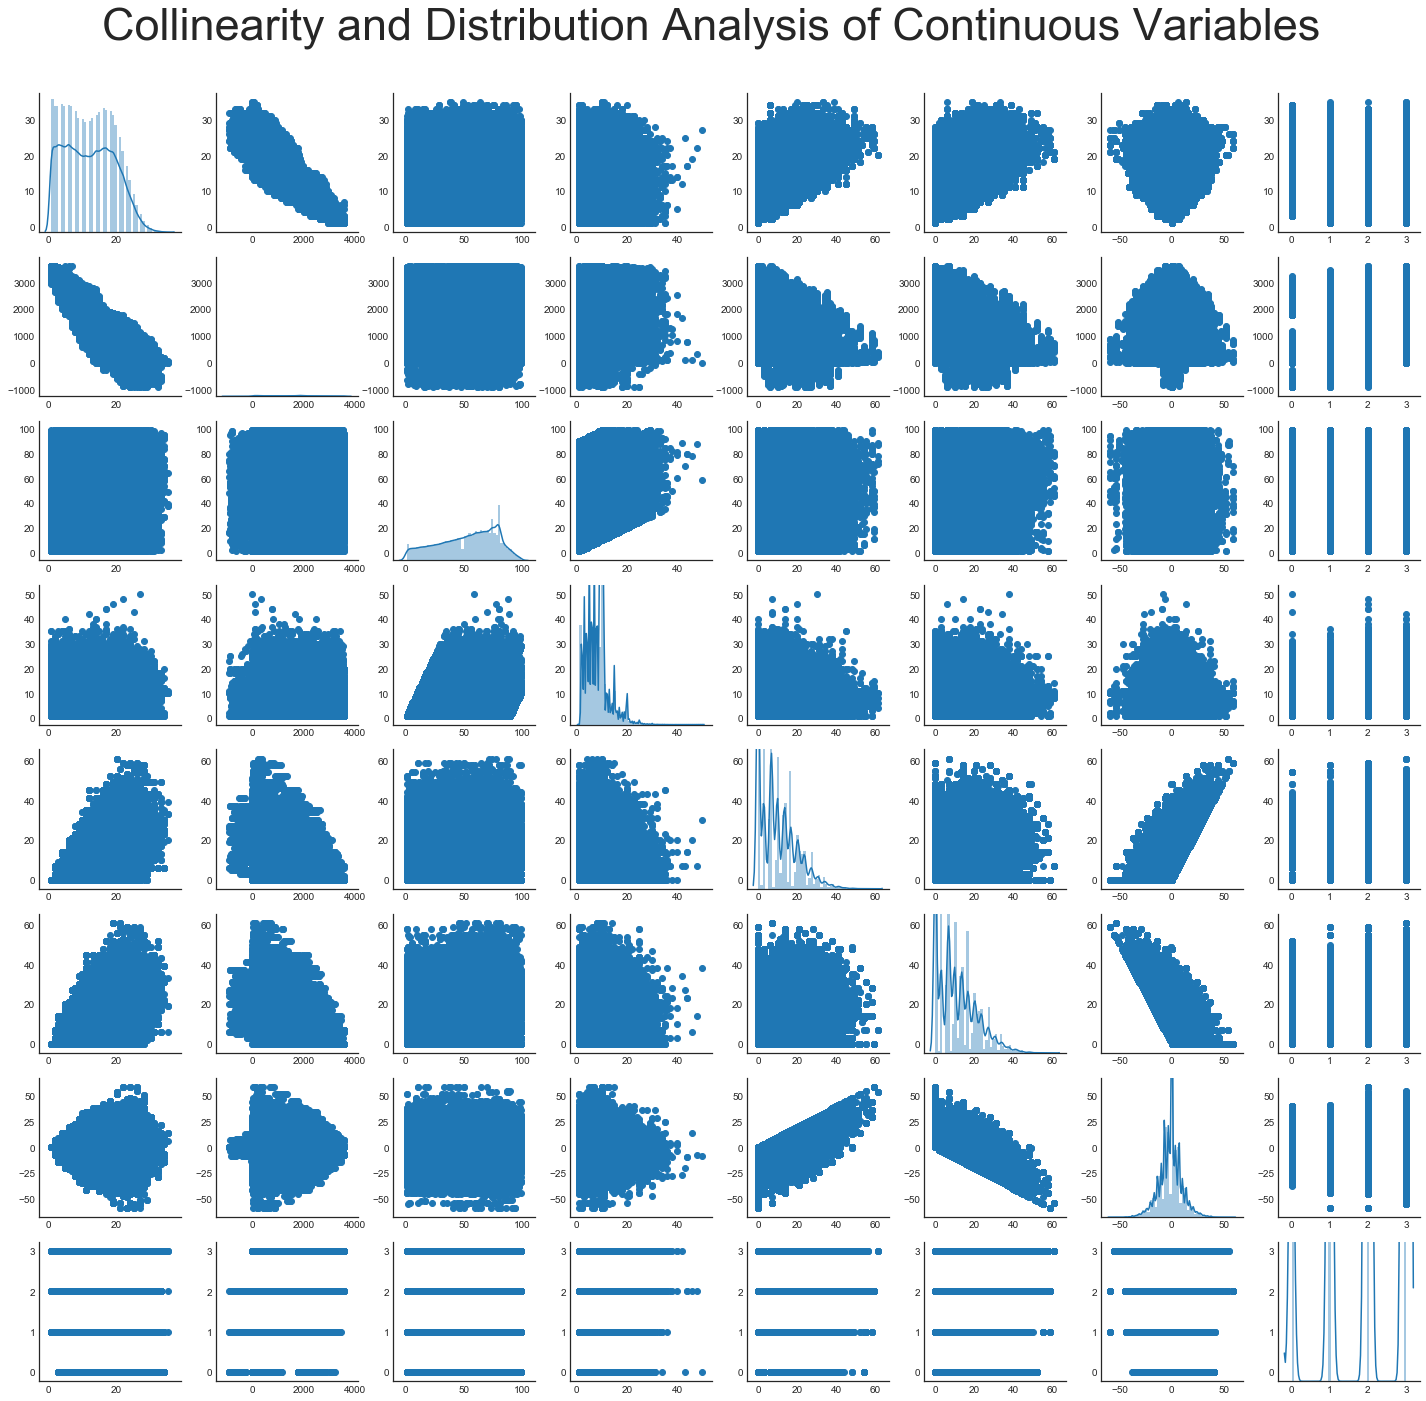

In [22]:
sns.set_style('white')
g = sns.PairGrid(cont, despine=True)

g.map_diag(sns.distplot)
g.map_offdiag(plt.scatter)
for ax in g.axes.flatten():
    ax.set_ylabel('')
    ax.set_xlabel('')

g.fig.suptitle('Collinearity and Distribution Analysis of Continuous Variables \n', fontsize=45)
plt.subplots_adjust(top=0.92)
plt.show()

                   Drive  TimeSecs  yrdline100  ydsfrom1stdown  OffTeamScore  \
Drive           1.000000 -0.943548   -0.013830        0.022242      0.666066   
TimeSecs       -0.943548  1.000000    0.066493       -0.010125     -0.676789   
yrdline100     -0.013830  0.066493    1.000000        0.231691     -0.025704   
ydsfrom1stdown  0.022242 -0.010125    0.231691        1.000000      0.006267   
OffTeamScore    0.666066 -0.676789   -0.025704        0.006267      1.000000   
DefTeamScore    0.667269 -0.683320    0.003238        0.017767      0.386280   
ScoreDiff      -0.037186  0.042716   -0.025488       -0.011020      0.515851   
OffTimeouts    -0.286669  0.312748    0.060667       -0.006588     -0.202339   
Touchdown      -0.003928 -0.012735   -0.276037       -0.132329     -0.000894   

                DefTeamScore  ScoreDiff  OffTimeouts  Touchdown  
Drive               0.667269  -0.037186    -0.286669  -0.003928  
TimeSecs           -0.683320   0.042716     0.312748  -0.012735  
y

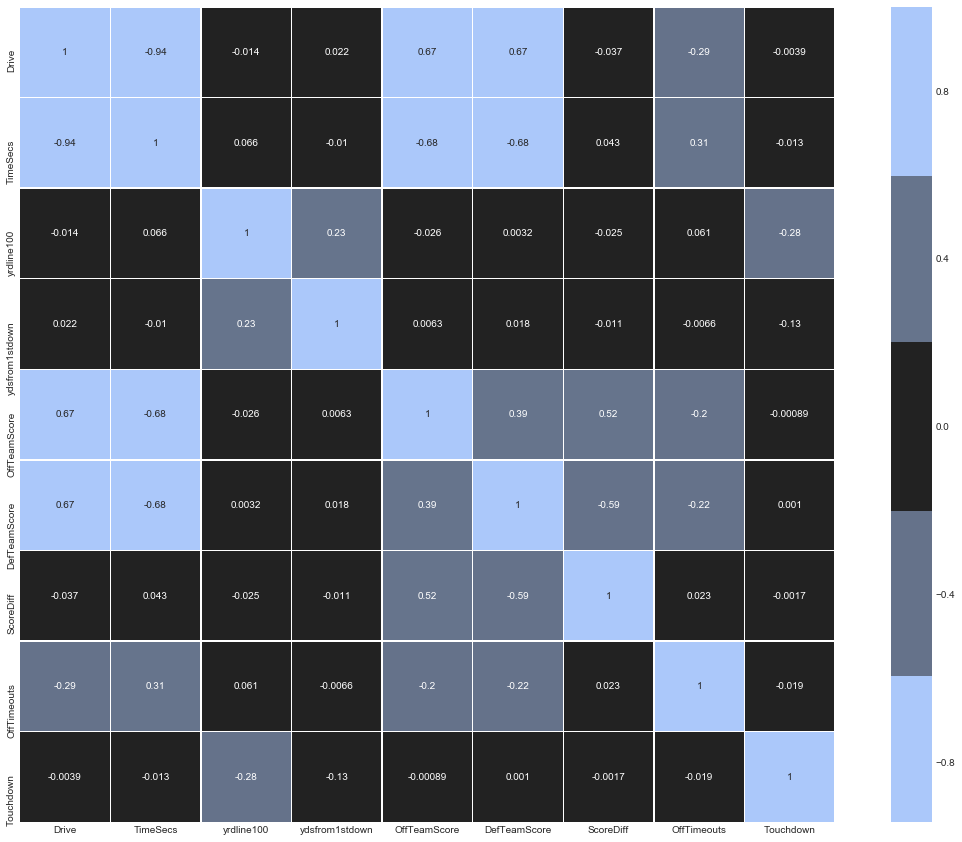

In [23]:
# Make the correlation matrix.
corrmat = pd.concat([cont,Y], axis=1).corr()
print(corrmat)

# Set up the matplotlib figure.
f, ax = plt.subplots(figsize=(20, 15))

# Draw the heatmap using seaborn.
color = sns.diverging_palette(250, 250, s=90, l=80, sep=5, n=5, center='dark')
ax = sns.heatmap(corrmat, center=0, annot=True, linewidths=.5, cmap=color, square=True)
plt.show()

It looks like we have a few outliers in the score related features (OffTeamScore, DefTeamScore & ScoreDiff). Looking at the distribution of the features however, all the outliers look within the normal range of values.

We also have some collinearity amongst the features. Let's remove a few to help tamp down bias and skew in our models:
- **Drive and TimeSecs**: we'll remove Drive as TimeSecs is a more descriptive feature for the same basic information
- **Team Score Data**: we'll remove OffTeamScore given that the combination of features DefTeamScore and ScoreDiff will provide the same amount of information.

In [24]:
del X['Drive']
del X['DefTeamScore']

Next, we'll take a look at the categorical variables to see the relation to the desired outcome variable

In [25]:
# Create data sets for touchdown per play ratios by down
td_down_percentages = pd.crosstab(plays.down, plays.Touchdown)
td_down_percentages['percent'] = td_down_percentages[1]/(td_down_percentages[0] + td_down_percentages[1])
td_down_percentages['down'] = [1, 2, 3, 4]
td_down_percentages

Touchdown,0,1,percent,down
down,,,,
1.0,126120,4394,0.033667,1
2.0,93904,3714,0.038046,2
3.0,58499,3054,0.049616,3
4.0,3947,379,0.087610,4


In [26]:
# Create data sets for touchdown per play ratios by quarter
td_qtr_percentages = pd.crosstab(plays.qtr, plays.Touchdown)
td_qtr_percentages['percent'] = td_qtr_percentages[1]/(td_qtr_percentages[0] + td_qtr_percentages[1])
td_qtr_percentages['qtr'] = td_qtr_percentages.index
td_qtr_percentages

Touchdown,0,1,percent,qtr
qtr,,,,
1,64145,2270,0.034179,1
2,74911,3382,0.043197,2
3,64572,2500,0.037273,3
4,76826,3353,0.041819,4
5,2016,36,0.017544,5


In [27]:
# Create data sets for touchdown per play ratios by weekday
td_weekday_percentages = pd.crosstab(plays.weekday, plays.Touchdown)
td_weekday_percentages['percent'] = td_weekday_percentages[1]/(td_weekday_percentages[0] + td_weekday_percentages[1])
td_weekday_percentages['weekday'] = td_weekday_percentages.index
reorder_index = pd.Index(['Mon','Tue','Wed','Thur','Fri','Sat','Sun'])
td_weekday_percentages = td_weekday_percentages.reindex_axis(reorder_index, axis=0)
td_weekday_percentages

Touchdown,0,1,percent,weekday
Mon,18533,789,0.040834,Mon
Tue,124,6,0.046154,Tue
Wed,106,5,0.045045,Wed
Thur,16270,667,0.039381,Thur
Fri,110,8,0.067797,Fri
Sat,4708,202,0.041141,Sat
Sun,242619,9864,0.039068,Sun


In [28]:
# Create data sets for touchdown per play ratios by week
td_week_percentages = pd.crosstab(plays.week, plays.Touchdown)
td_week_percentages['percent'] = td_week_percentages[1]/(td_week_percentages[0] + td_week_percentages[1])
td_week_percentages['week'] = td_week_percentages.index
td_week_percentages

Touchdown,0,1,percent,week
week,,,,
1,17401,706,0.038990,1
2,17639,709,0.038642,2
3,17672,732,0.039774,3
4,16394,684,0.040052,4
5,15442,631,0.039258,5
6,15936,647,0.039016,6
7,15482,630,0.039101,7
8,14986,613,0.039297,8
9,14618,648,0.042447,9


<function matplotlib.pyplot.show>

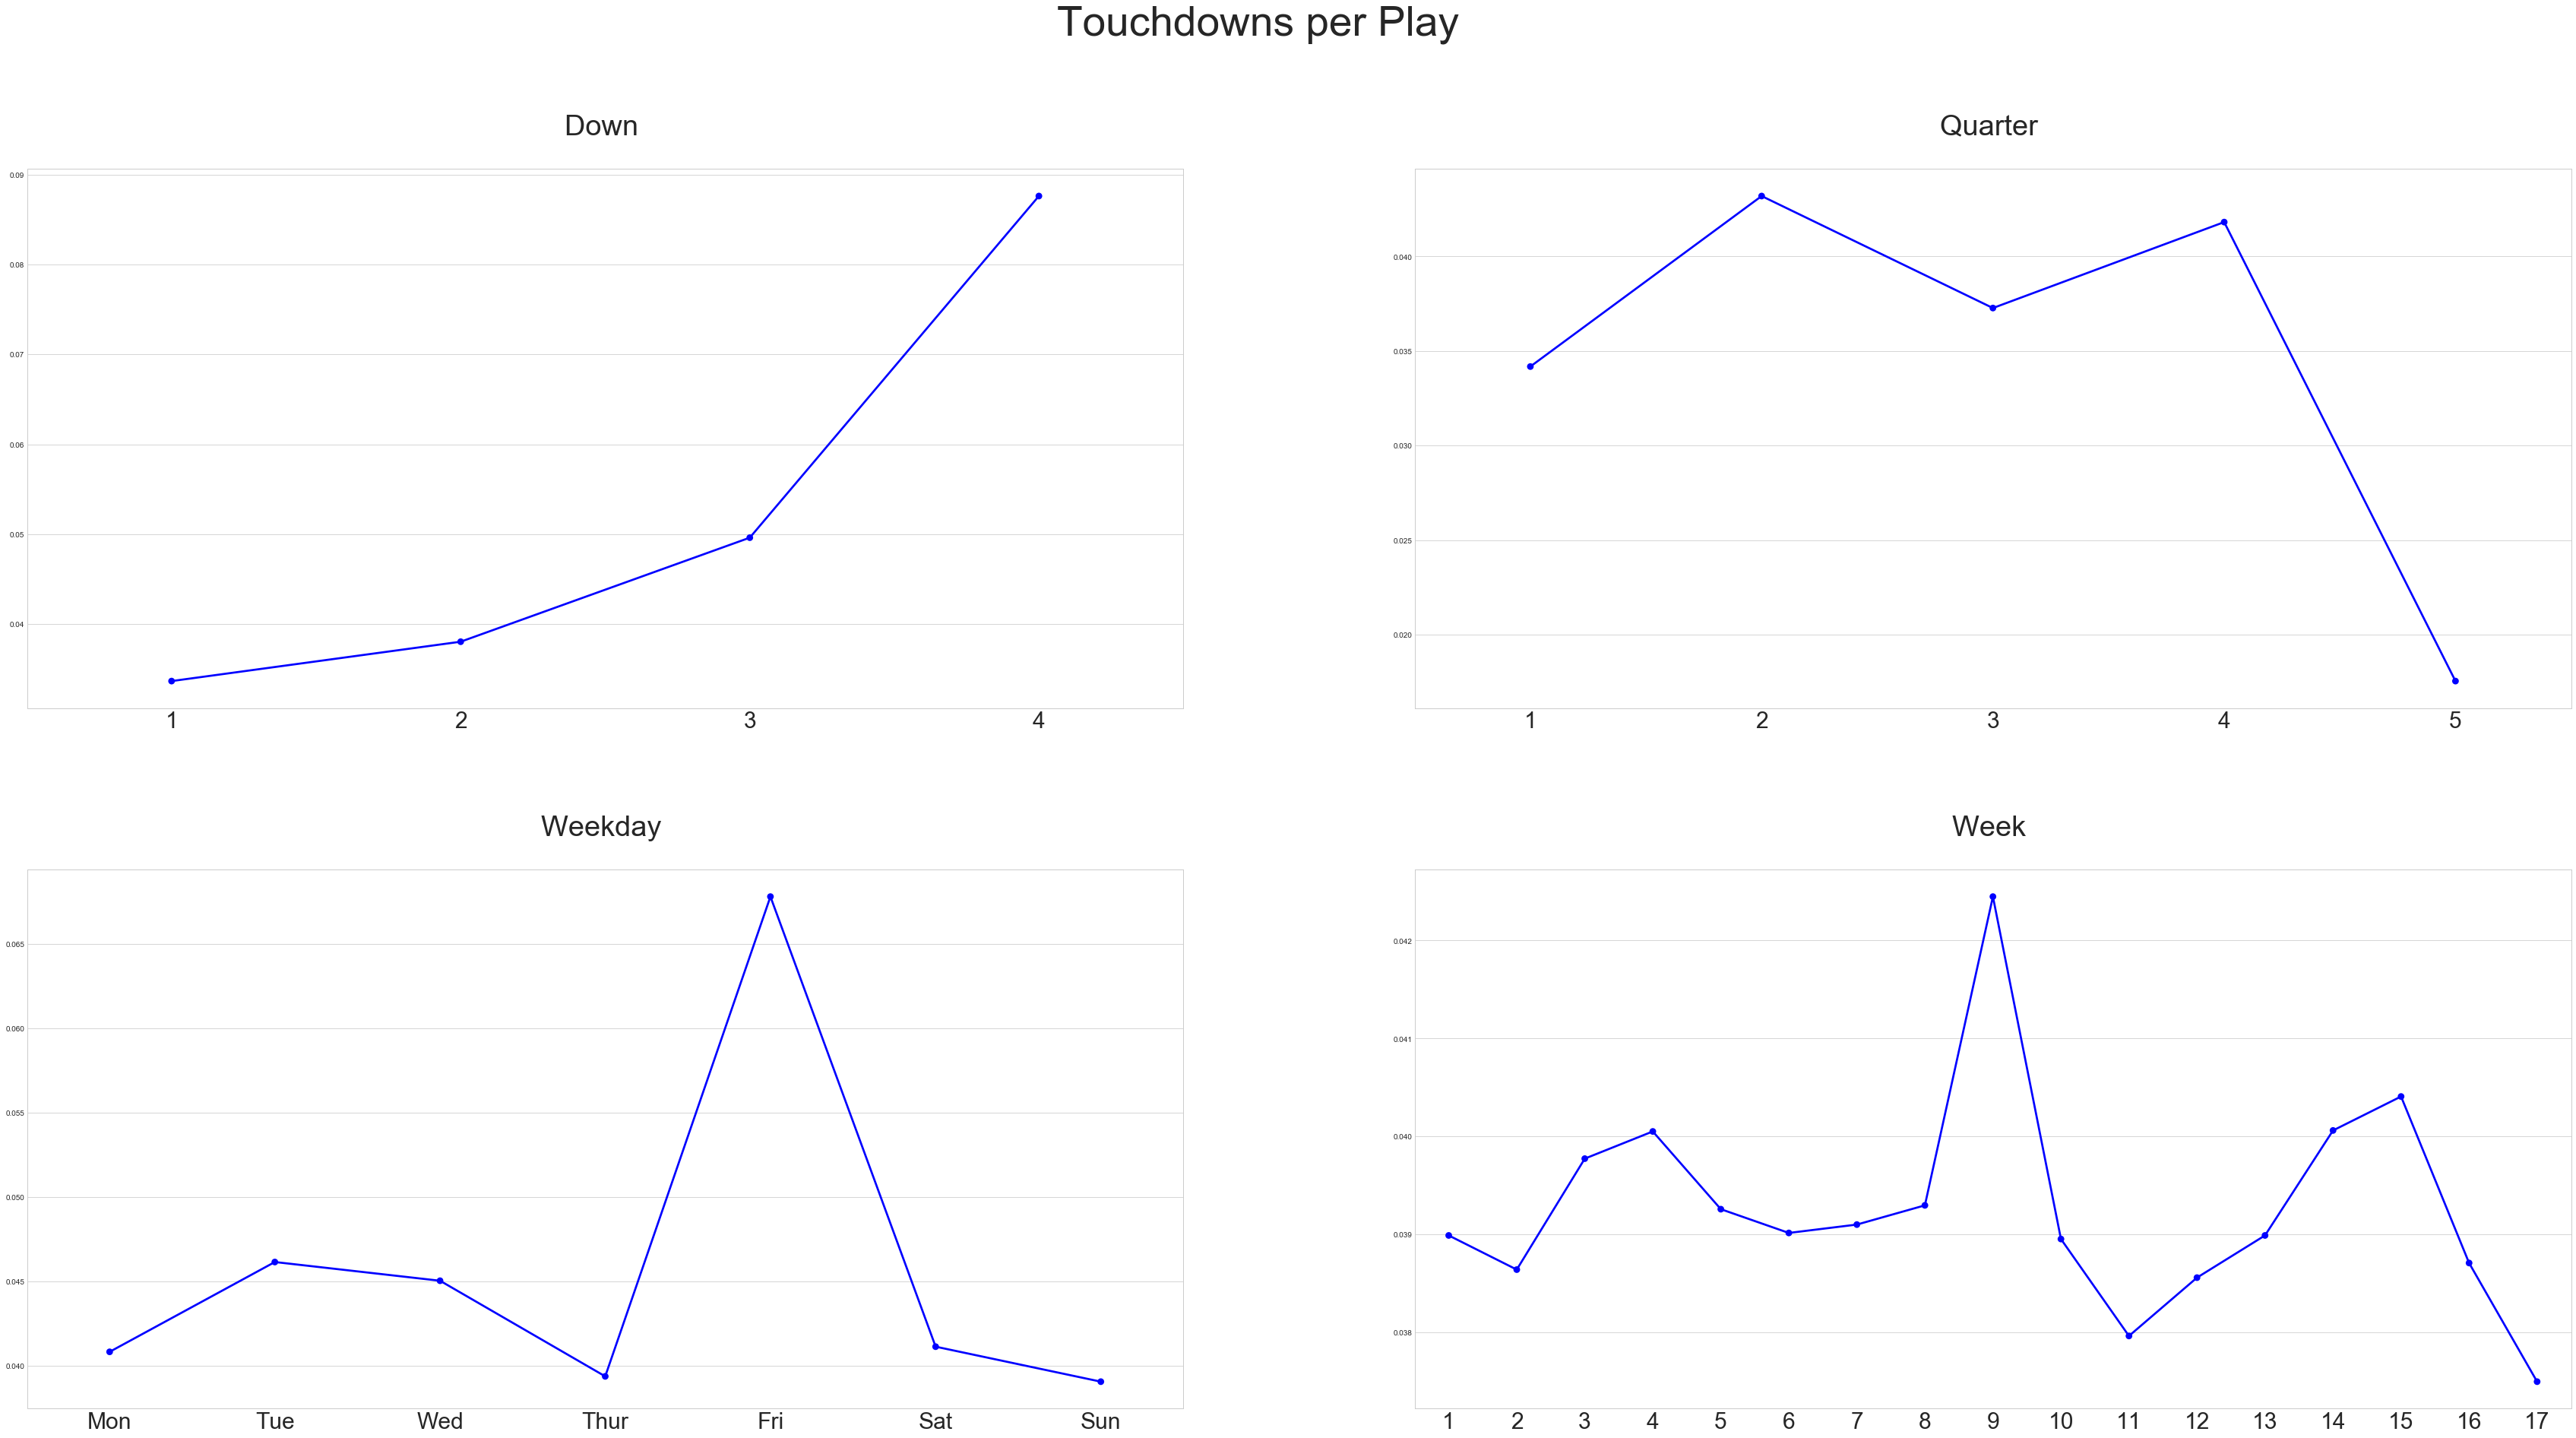

In [29]:
# Set style and figure shape
sns.set_style('whitegrid')
f, ax = plt.subplots(figsize=(60,30))

# Plot all ratios
plt.subplot(2,2,1)
sns.pointplot(x='down', y='percent', data=td_down_percentages, color='b')
plt.xlabel('')
plt.ylabel('')
plt.xticks(fontsize=30)
plt.title('Down \n', fontsize=38)

plt.subplot(2,2,2)
sns.pointplot(x='qtr', y='percent', data=td_qtr_percentages, color='b')
plt.xlabel('')
plt.ylabel('')
plt.xticks(fontsize=30)
plt.title('Quarter \n', fontsize=38)

plt.subplot(2,2,3)
sns.pointplot(x='weekday', y='percent', data=td_weekday_percentages, color='b')
plt.xlabel('')
plt.ylabel('')
plt.xticks(fontsize=30)
plt.title('Weekday \n', fontsize=38)

plt.subplot(2,2,4)
sns.pointplot(x='week', y='percent', data=td_week_percentages, color='b')
plt.xlabel('')
plt.ylabel('')
plt.xticks(fontsize=30)
plt.title('Week \n', fontsize=38)


f.subplots_adjust(hspace=.3)
plt.suptitle('Touchdowns per Play', fontsize=55)
plt.show

In [30]:
# Creating DataFrame for plotting differences between teams
df = plays[['Drive','Touchdown','HomeTeam','AwayTeam','Offense','Defense']]

# Creating additional column to distinguish between games
index_tracker = []
for i in range(1, len(df.index)):
    if df.iloc[i,0] < df.iloc[i-1,0]:
        index_tracker.append(df.index[i])
        
df['game'] = 1
counter = 2

for i in index_tracker:
    df.loc[i:,'game'] = counter
    counter = counter+1

/Users/Albert/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/Albert/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [31]:
# Separate into Offense and Defense data sets
Offense = df.drop('Defense', axis=1)
Defense = df.drop('Offense', axis=1)

# Create datasets for plotting
Offense['Home_Away'] = 'Home'
for i in range(1, len(Offense.index)):
    if Offense.iloc[i-1,4] != Offense.iloc[i,4]:
        if Offense.iloc[i,4] == Offense.iloc[i,2]:
            Offense.iloc[i:,6] = 'Home'
        elif Offense.iloc[i,4] == Offense.iloc[i,3]:
            Offense.iloc[i:,6] = 'Away'
            
Offense = pd.crosstab(index=[Offense.game, Offense.Offense, Offense.Home_Away], columns=Offense.Touchdown)
Offense['percent'] = Offense[1]/(Offense[0] + Offense[1])
Offense = Offense.reset_index()

Defense['Home_Away'] = 'Away'
for i in range(1, len(Defense.index)):
    if Defense.iloc[i-1,4] != Defense.iloc[i,4]:
        if Defense.iloc[i,4] == Defense.iloc[i,2]:
            Defense.iloc[i:,6] = 'Home'
        elif Defense.iloc[i,4] == Defense.iloc[i,3]:
            Defense.iloc[i:,6] = 'Away'
            
Defense = pd.crosstab(index=[Defense.game, Defense.Defense, Defense.Home_Away], columns=Defense.Touchdown)
Defense['percent'] = Defense[1]/(Defense[0] + Defense[1])
Defense = Defense.reset_index()

<function matplotlib.pyplot.show>

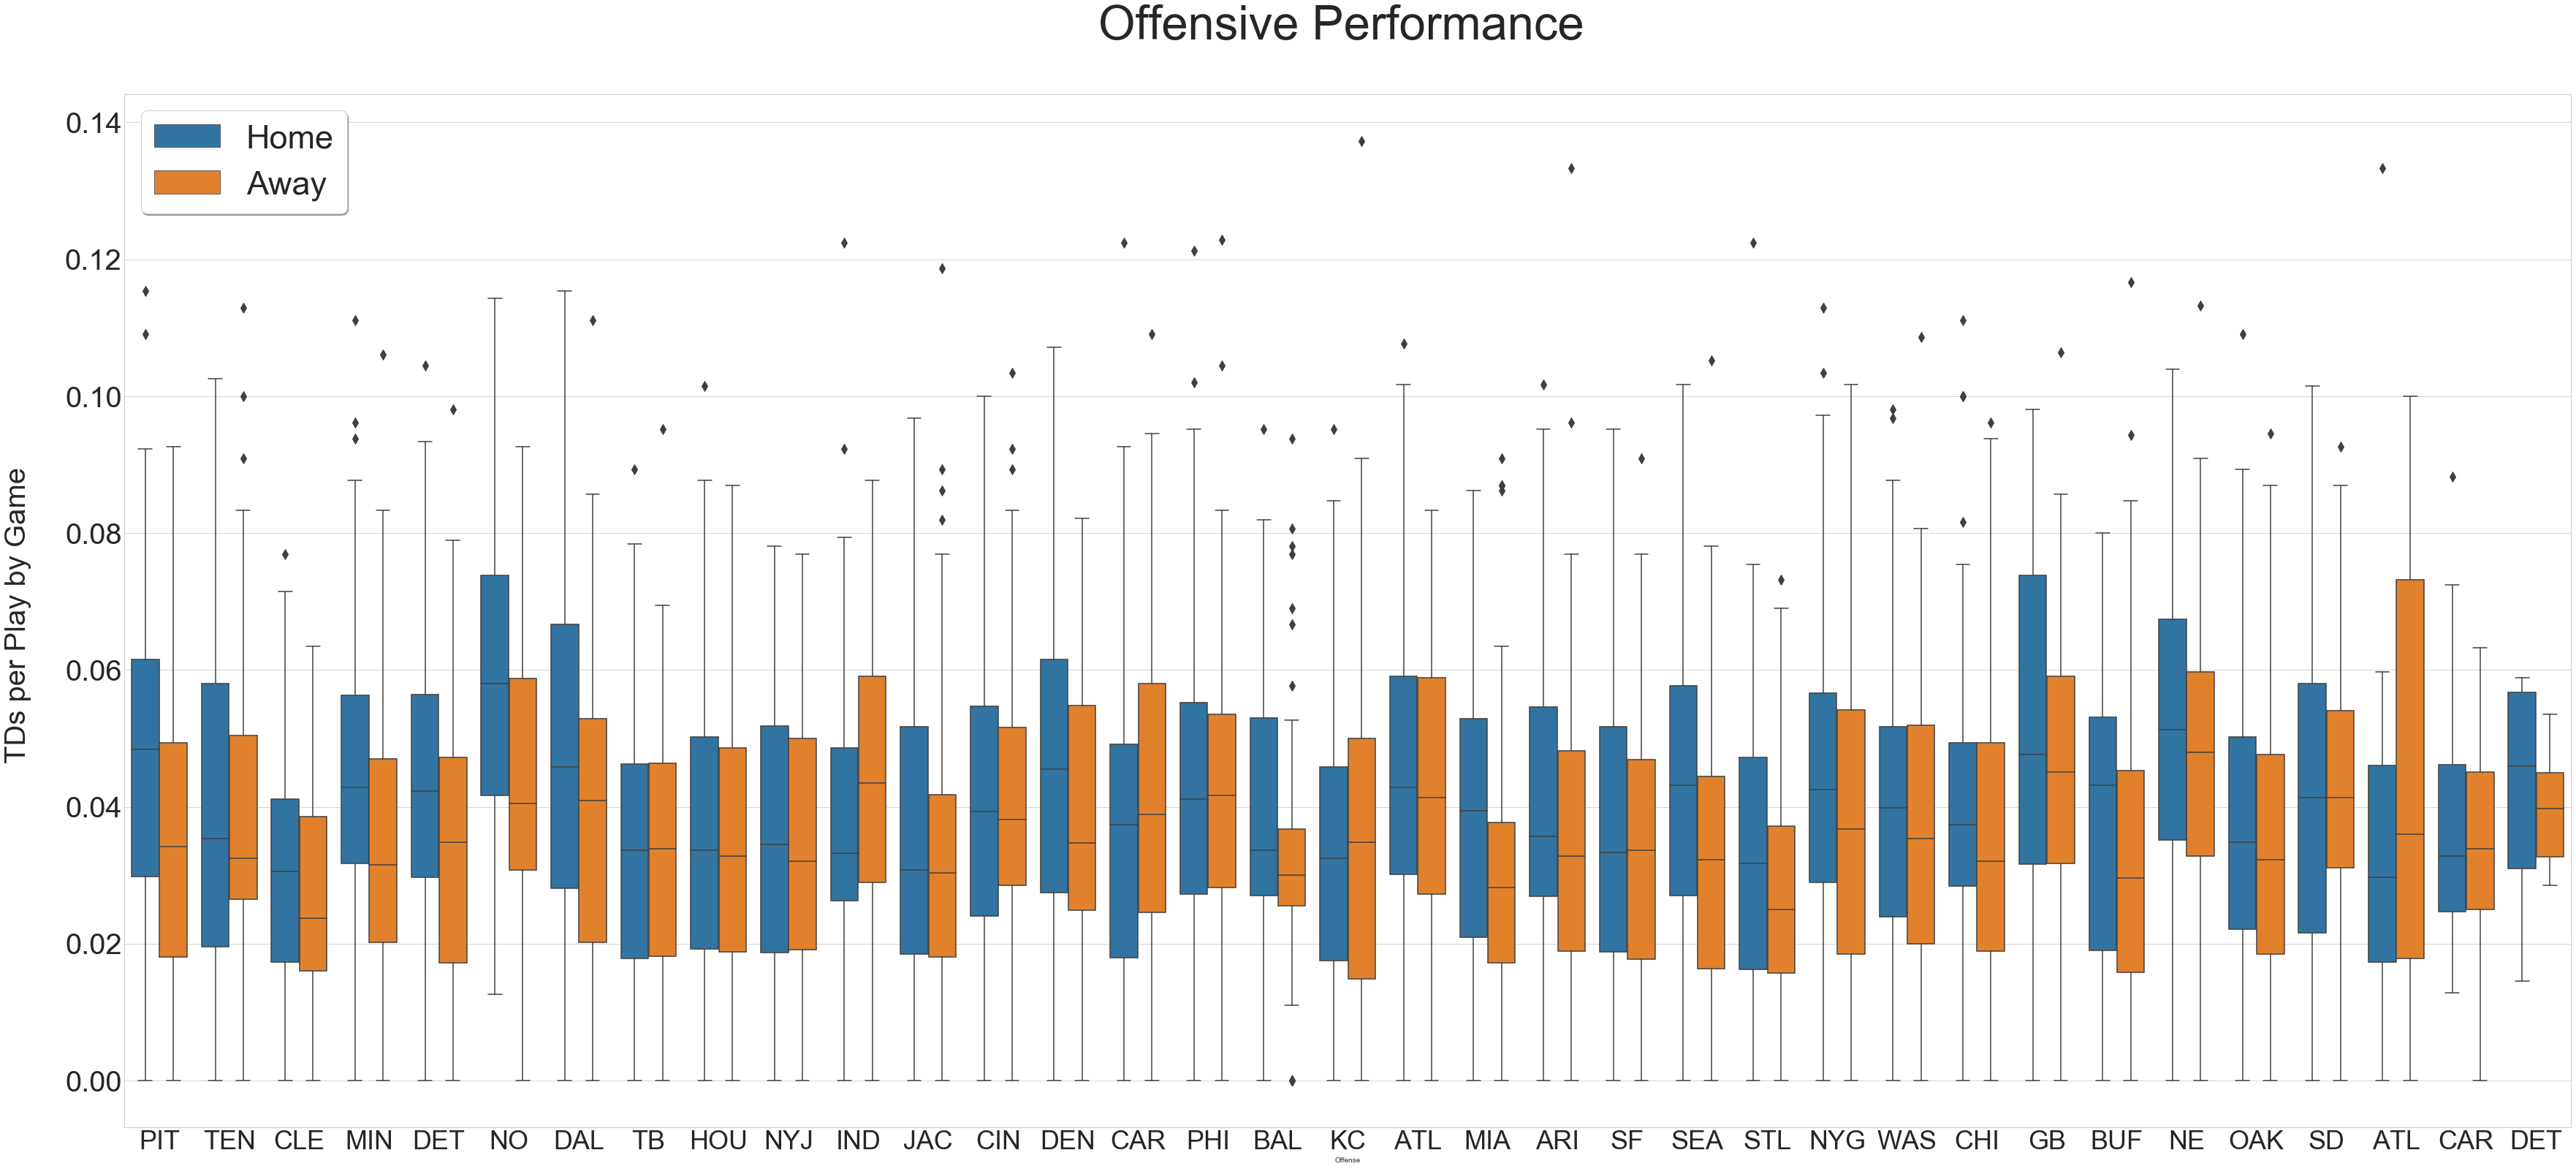

In [32]:
# Plotting offensive performance
plt.figure(figsize=(60,26))
ax = sns.boxplot(x='Offense', y='percent', hue='Home_Away', data=Offense, fliersize=10)
ax.set_xticklabels(labels=Offense.Offense, fontsize=36)
ax.legend(fontsize=45, title='', loc=0, frameon=True, shadow=True)
plt.yticks(fontsize=40)
plt.ylabel('TDs per Play by Game \n', fontsize=40)
plt.title('Offensive Performance \n', fontsize=65)
plt.show

<function matplotlib.pyplot.show>

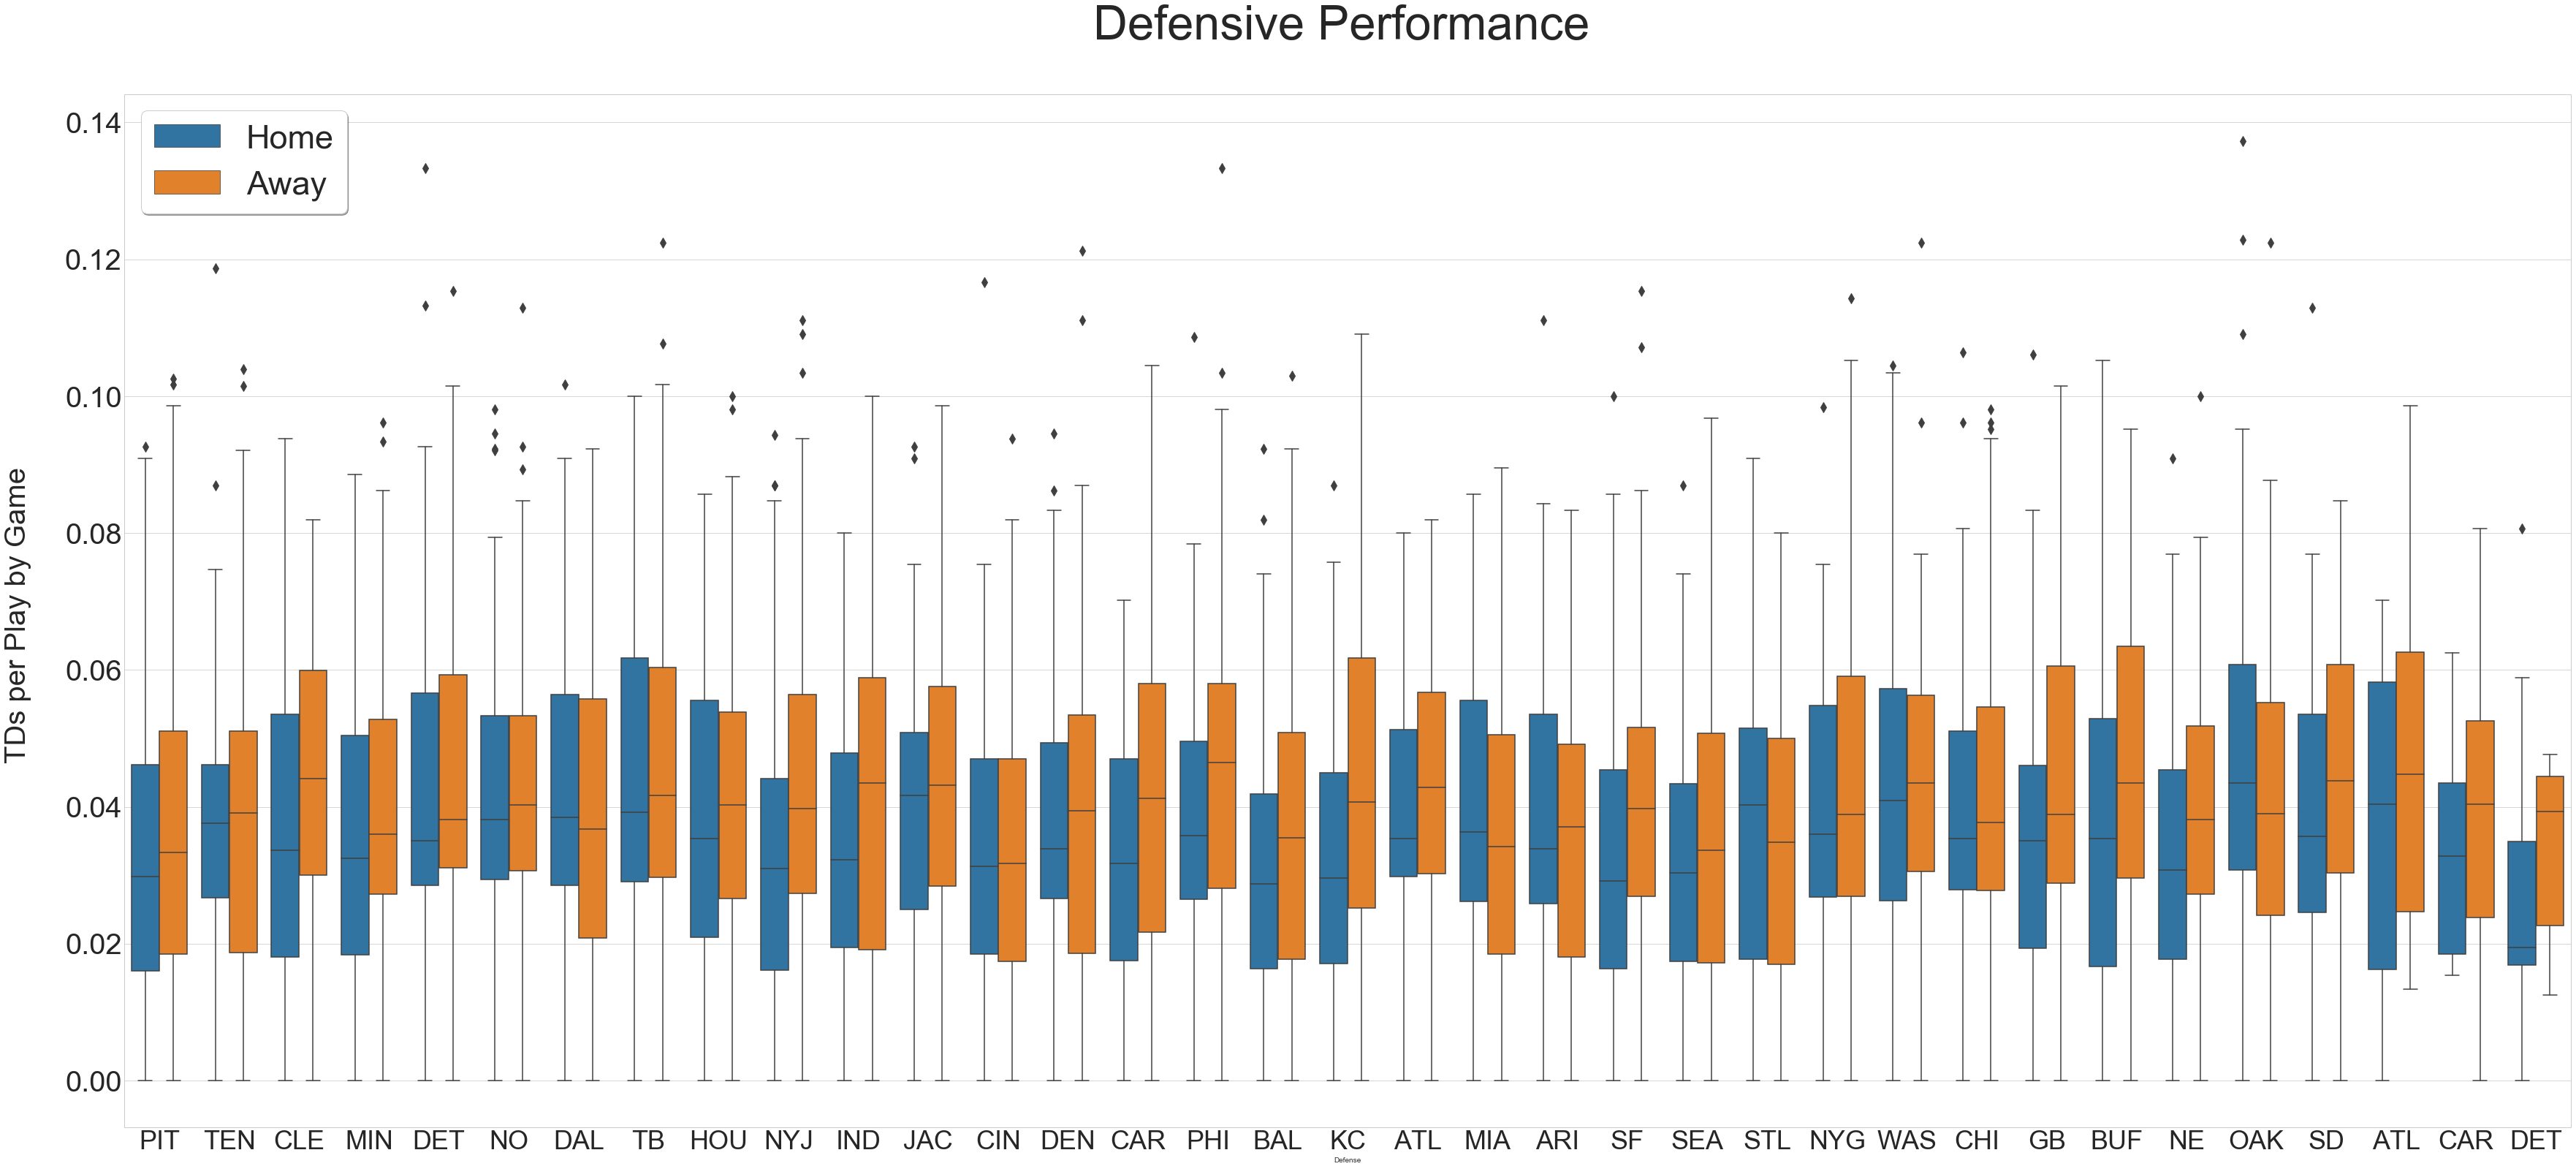

In [33]:
# Plotting defensive performance
plt.figure(figsize=(60,26))
ax = sns.boxplot(x='Defense', y='percent', hue='Home_Away', data=Defense, fliersize=10)
ax.set_xticklabels(labels=Defense.Defense, fontsize=36)
ax.legend(fontsize=45, title='', loc=2, frameon=True, shadow=True)
plt.yticks(fontsize=40)
plt.ylabel('TDs per Play by Game \n', fontsize=40)
plt.title('Defensive Performance \n', fontsize=65)
plt.show

**Summary**

Time sensitive categorical features (down, quarter, weekday and week) all have clear discrepancies in the likelihood of touchdowns being scored on that particular play. Some patterns are more interpretable (downs, quarters), while others such as week are less clear but important nevertheless.

The same is true for team oriented features, regarding Offensive and Defensive team play both away and at home.


Because of this impact, we will retain all categorical data in the form of dummy variables.



**Details**:
Likelihood to score increases for:

- Later downs (3/4)
- End of half, in other words 2nd and 4th quarters
- Non-standard weekday play, such as Tuesday, Wednesday and Friday
- Mid-season, in other words week 9
- Home games, both on Offense and Defense with more consistent and predictable performance


Time sensitive categorical features (down, quarter, weekday and week) all have clear discrepancies in the likelihood of touchdowns being scored on that particular play. Some patterns are more interpretable (downs, quarters), while others such as week are less clear but important nevertheless.

The same is true for team oriented features, regarding Offensive and Defensive team play both away and at home

In [34]:
# Creating dummy variables

X = pd.get_dummies(X, columns=['qtr','down','Offense','Defense','HomeTeam','AwayTeam','weekday','week'])
print(X.shape)
X.head()

(294011, 179)


,TimeSecs,yrdline100,ydsfrom1stdown,OffTeamScore,ScoreDiff,OffTimeouts,qtr_1,qtr_2,qtr_3,qtr_4,...,week_8,week_9,week_10,week_11,week_12,week_13,week_14,week_15,week_16,week_17
1,3593.0,58.0,10,0.0,0.0,3,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3556.0,53.0,5,0.0,0.0,3,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3515.0,56.0,8,0.0,0.0,3,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,3496.0,98.0,10,0.0,0.0,3,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,3460.0,98.0,10,0.0,0.0,3,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We're left with **294011 observations** and **14 features** -- 6 continuous and 8 categorical features (represented by 173 dummy variables)

That's a pretty sizable dataset! Now that we've done our due diligence, let's get to modeling!

# Modeling

In [35]:
# Importing all sklearn functions we'll be using

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.preprocessing import normalize as Norm
from sklearn.svm import LinearSVC as SVC
import time

### 1) Regression

We'll start with the simplest of models - the regression. There wasn't much collinearity between any of the features and the desired outcome variable Touchdown. But due to the ease and simplicity of the model in addition to the coefficents that it can provide, it's worth a try.

We did see some mild colinearity even after data cleaning, so we'll also loop through a few L2 regularization parameters to see if there is any improvements in the model.

In [36]:
# Establishing values to iterate through to optimize regularization strength for L1 and L2 regularization
reg_strength_sub1 = np.arange(0.1,1,0.1)
reg_strength_above1 = np.arange(5,101,5)


# Determining optimal C value for Ridge
ridge_scores = []

for i in reg_strength_sub1:
    model = LogisticRegression(C=i)
    score = cross_val_score(model,X,Y,cv=5)
    ridge_scores.append((i, np.mean(score), np.var(score)))

for i in reg_strength_above1:
    model = LogisticRegression(C=i)
    score = cross_val_score(model,X,Y,cv=5)
    ridge_scores.append((i, np.mean(score), np.var(score)))

df_ridge = pd.DataFrame(np.array(ridge_scores), columns=['C', 'score', 'variance'])
df_ridge

,C,score,variance
0,0.1,0.960746,4.271117e-11
1,0.2,0.960746,4.271117e-11
2,0.3,0.960746,4.271117e-11
3,0.4,0.960746,4.271117e-11
4,0.5,0.960746,4.271117e-11
5,0.6,0.960746,4.271117e-11
6,0.7,0.960746,4.271117e-11
7,0.8,0.960746,4.271117e-11
8,0.9,0.960746,4.271117e-11
9,5.0,0.960746,4.271117e-11


Clearly regularization has negligile impact on the resulting scores, and the variance indicates there are no aberrations in any of our k-folds.

Let's wrap up our regression analysis then with a simple Logistic Regression, and also time our model to get a feel for how long a prediction would take in a live environment.

In [37]:
# Setting up model
log_regr = LogisticRegression()

# Testing regression accuracy using 5-fold cross validation
#print(cross_val_score(log_regr, X, Y, cv=5))

In [38]:
log_regr.fit(X,Y)
start_time = time.time()
log_regr.predict(X)
print(time.time() - start_time)

0.45639777183532715


Consistently accurate across all folds - not too shabby!

### 2) KNN

But let's continue to see if any other methods can improve even further.

For our KNN Classifier, we'll first have to rescale our data.

In [39]:
# Normalizing data for regularization coefficients and KNN model

X_scaled = Norm(X)

Now we'll run a similar for loop as for our regressions above to help estimate the best k-value and determine whether weighting improves performance.

In [40]:
# Create function to help determine the best K-value for KNN

def kvalue_testing (X, Y, weighted=False):
    
    # Create list of k-values to test
    neighbors = list(range(5,50,2))

    # Create empty list to hold test scores
    knn_scores = []

    # Perform 5-fold cross validation and store all scores
    if weighted:
        for k in neighbors:
            knn = KNN(n_neighbors=k, weights='distance')
            scores = cross_val_score(knn,X,Y,cv=5)
            knn_scores.append(np.mean(scores))
    else:
        for k in neighbors:
            knn = KNN(n_neighbors=k)
            scores = cross_val_score(knn,X,Y,cv=5)
            knn_scores.append(np.mean(scores))

    # Changing to misclassification error
    MSE = [1 - x for x in knn_scores]

    # Determining best k
    optimal_k = neighbors[MSE.index(min(MSE))]
    print ("The optimal number of neighbors is {}".format(optimal_k))

    # Plot misclassification error vs k
    plt.plot(neighbors, MSE)
    plt.xlabel('Number of Neighbors K')
    plt.ylabel('Misclassification Error')
    plt.show()

The optimal number of neighbors is 49


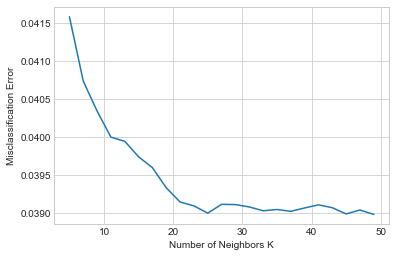

In [ ]:
kvalue_testing (X_scaled, Y, weighted=False)

In [ ]:
kvalue_testing (X_scaled, Y, weighted=True)

In [ ]:
# Setting up model
knn = KNN(n_neighbors=45, weights='distance')

# Testing regression accuracy using 5-fold cross validation
#print(cross_val_score(knn, X_scaled, Y, cv=5))

In [ ]:
knn.fit(X_scaled,Y)
start_time = time.time()
knn.predict(X_scaled)
print(time.time() - start_time)

### 3) SVM

Because it was clear in our linear regressions that adding a regularization term had little impact on the results, we'll avoid it here in our SVC model

In [ ]:
svc = SVC()
#print(cross_val_score(svc, X, Y, cv=5))

In [ ]:
svc.fit(X,Y)
start_time = time.time()
svc.predict(X)
print(time.time() - start_time)

Looks like there's an aberration in our 5th testing fold - it appears some of the data in our model messed with kernel selection

### 4) Random Forest

Lastly, we'll run a Random Forest as it is both a highly successful model and also provides a lot of information with it's feature importances attribute.

In [ ]:
rfc = RFC(n_estimators=100, max_leaf_nodes=15)
print(cross_val_score(rfc, X, Y, cv=5))

In [ ]:
rfc.fit(X,Y)
start_time = time.time()
rfc.predict(X)
print(time.time() - start_time)

So... it seems like each of our models has about the same predictive power. This is most likely an indicator that the missing 4% of accuracy is unexplainable with the variables present, and would require some additional information.

That said, there is still some more interesting information to be drawn from our little experiment.

## Feature Importance

The last thing we'll do here is take some of our models, and see if they can help us determine which of these features are most impactful on predicting and, dare I say... producing, touchdowns. 

In [ ]:
# Pull out feature importances
log_importance = abs(log_regr.coef_)
svc_importance = abs(svc.coef_)
rfc_importance = rfc.feature_importances_

# Set importances as a relative percentage
log_importance = 100.0 * (log_importance / log_importance.sum())
svc_importance = 100.0 * (svc_importance / svc_importance.sum())
rfc_importance = 100.0 * (rfc_importance / rfc_importance.sum())

# Set up DataFrames for plotting and sort
log_df = pd.DataFrame(data={'Percent_Importance':log_importance[0], 'Feature':X.columns})
log_df.sort_values('Percent_Importance', axis=0, ascending=False, inplace=True)

svc_df = pd.DataFrame(data={'Percent_Importance':svc_importance[0], 'Feature':X.columns})
svc_df.sort_values('Percent_Importance', axis=0, ascending=False, inplace=True)

rfc_df = pd.DataFrame(data={'Percent_Importance':rfc_importance, 'Feature':X.columns})
rfc_df.sort_values('Percent_Importance', axis=0, ascending=False, inplace=True)

In [ ]:
sns.set_style('white')
f, ax = plt.subplots(figsize=(60,30))

ax1 = plt.subplot(1, 3, 1)
sns.barplot(y='Feature', x='Percent_Importance', data=log_df.iloc[:20,:], palette='Blues_r')
plt.xticks(fontsize=25)
plt.xlabel('')
plt.yticks(fontsize=30)
ax1.tick_params(axis='y', which='major', pad=30)
plt.title('Logistic Regression \n', fontsize=40)

ax2 = plt.subplot(1, 3, 2)
sns.barplot(y='Feature', x='Percent_Importance', data=svc_df.iloc[:20,:], palette='Blues_r')
plt.xticks(fontsize=25)
plt.xlabel('\n Percent Importance', fontsize=50)
plt.yticks(fontsize=30)
ax2.tick_params(axis='y', which='major', pad=30)
plt.title('Linear SVC \n', fontsize=40)

ax3 = plt.subplot(1, 3, 3)
sns.barplot(y='Feature', x='Percent_Importance', data=rfc_df.iloc[:20,:], palette='Blues_r')
plt.xticks(fontsize=25)
plt.xlabel('')
plt.yticks(fontsize=30)
ax3.tick_params(axis='y', which='major', pad=30)
plt.title('Random Forest \n', fontsize=40)

plt.tight_layout()
plt.suptitle('         Highest Importance Features by Model \n', fontsize=70)
plt.subplots_adjust(top=0.88)
plt.show()

In [ ]:
sns.set_style('white')
f, ax = plt.subplots(figsize=(60,35))

ax1 = plt.subplot(1, 3, 1)
plt.barh(pos, log_importance[0][:15], align='center')
plt.yticks(pos, X.columns[sorted_idx], fontsize=45)
ax1.tick_params(axis='y', which='major', pad=150)
plt.xlabel('Relative Importance')
plt.title('Logistic Regression \n', fontsize=40)

ax2 = plt.subplot(1, 3, 2)
plt.barh(pos, svc_importance[0][:15], align='center')
plt.xlabel('Relative Importance')
plt.title('Linear SVC \n', fontsize=40)

plt.subplot(1, 3, 3)
plt.barh(pos, rfc_importance[:15], align='center')
#plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Random Forest \n', fontsize=40)

plt.suptitle('Highest Importance Features by Model \n', fontsize=70)
plt.subplots_adjust(top=0.9)
plt.show()

In [ ]:
# Make importances relative to max importance.
log_importance = abs(100.0 * (log_importance / log_importance.max()))
svc_importance = abs(100.0 * (svc_importance / svc_importance.max()))
rfc_importance = 100.0 * (rfc_importance / rfc_importance.max())

# Create single index of top 15 important features for each algorithm
sorted_idx = list(np.argsort(log_importance)[0][:15])
for idx in list(np.argsort(svc_importance)[0][:15]):
    if idx not in sorted_idx:
        sorted_idx.append(idx)
for idx in list(np.argsort(rfc_importance)[:15]):
    if idx not in sorted_idx:
        sorted_idx.append(idx)
sorted_idx = np.asarray(sorted_idx)

pos = np.arange(sorted_idx.shape[0]) + .5

In [ ]:
log_importance_top15

In [ ]:
# Ceate Dataframes for plotting
log_df = pd.DataFrame(data={'Feature Name':X.columns[sorted_idx], 'Feature Importance':log_importance[0][sorted_idx],
                            'Model':'Logistic Regression'})

svc_df = pd.DataFrame(data={'Feature Name':X.columns[sorted_idx], 'Feature Importance':svc_importance[0][sorted_idx],
                            'Model':'Linear SVC'})

rfc_df = pd.DataFrame(data={'Feature Name':X.columns[sorted_idx], 'Feature Importance':rfc_importance[sorted_idx],
                            'Model':'Random Forest'})

plot_df = pd.concat([log_df, svc_df, rfc_df])

In [ ]:
# Plot comparative barplot

plt.figure(figsize=(30,35))

sns.barplot(x='Feature Name', y='Feature Importance', hue='Model', data=plot_df)

## Conclusions

In [ ]:
plays.columns

In [ ]:
down_dummies = pd.get_dummies(plays, columns=['down'])
qtr_dummies = pd.get_dummies(plays, columns=['qtr'])
offense_dummies = pd.get_dummies(plays, columns=['Offense'])
defense_dummies = pd.get_dummies(plays, columns=['Defense'])
hometeam_dummies = pd.get_dummies(plays, columns=['HomeTeam'])
awayteam_dummies = pd.get_dummies(plays, columns=['AwayTeam'])
week_dummies = pd.get_dummies(plays, columns=['week'])
weekday_dummies = pd.get_dummies(plays, columns=['weekday'])

In [ ]:
import mca

down_dummy = mca.MCA(pd.DataFrame(plays.down))

In [ ]:
mca_down = mca.MCA(down_dummy)

In [ ]:
mca_qtr = mca.MCA(qtr_dummies)

In [ ]:
qtr_dummy = mca.dummy(qtr_dummies)
offense_dummy = mca.dummy(offense_dummies)
defense_dummy = mca.dummy(defense_dummies)
hometeam_dummy = mca.dummy(hometeam_dummies)
awayteam_dummy = mca.dummy(awayteam_dummies)
week_dummy = mca.dummy(week_dummies)
weekday_dummy = mca.dummy(weekday_dummies)

#### The Model
Given certain data points before a snap, we are able to predict with 96% accuracy whether a touchdown will be scored on that given play. Given that we pulled the same results running 4 different modeling techniques, it's clear that there are some variables not present that explain the remaining 4%. Any further improvements in the models could come only with these added data.

#### Application
The model can have some application in the gambling space, and the dataset itself is rich enough to ask and tackle other gambling-based questions and problems. 

#### Improvements
As far as being able to dive into the greatest individual predictors for producing touchdowns, we unfortunately ran into some issues. There appears to be a general trend as far as the teams playing having a large impact. But there are undoubtedly many different variables packaged into that single metric that could be grounds for further exploration.

Stay tuned!!